# Titanic: Machine Learning from Disaster

## Problem Definition

The Titanic training dataset provided by Kaggle is defined by a goal to create a model predicting if passengers in the test dataset survived or not.

[Described at Kaggle:](https://www.kaggle.com/c/titanic)

> Knowing from a training set of samples listing passengers who survived or did not survive the Titanic disaster, can our model determine based on a given test dataset not containing the survival information, if these passengers in the test dataset survived or not.

The background of the domain of our problem is described at Kaggle competition description page:

> The sinking of the RMS Titanic (...) occured on April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. (...)

That is equal to saying that survival rate was 32,5%.

> One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. (...)

> Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

Summing up with description:

> In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

### Importing necessary packages

In [105]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

#from xgboost.sklearn import XGBClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# additional
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

#### Importing data

In [106]:
training = pd.read_csv('data/train.csv')
testing = pd.read_csv('data/test.csv')

### Inspecting data provided

In [107]:
training.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [108]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


- Training data have missing values in Age, Cabin and Embarked column.

In [109]:
testing.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [110]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


- Testing data have missing values in Age, Fare, and Cabin column.

#### Merging training and testing data

Merge training and test data to perform the same operations on both dataset so our model will be able to use the same features for learning and predicting results.

In [111]:
combine = [training, testing]

In [112]:
training.describe(include=[np.object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Hodges, Mr. Henry Price",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


##### Cabin:
- contains a lot of missing values;
- is structured using letter and digit (possible deck area and cabin number).

Missing values will be set as additional category.
Multi-Cabins will be dropped leaving one letter-digit_range pair.
Cabin will be divided into two columns:
- categorical column with deck letter;
- categorical column with cabin number range.

##### Embarked:
- contains only one missing value;
- is structured as categorical with three values.

Missing value will be replaced with most frequent value.
Embarked will be transformed to categorical.

##### Name:
Contains unnecessary data about name and surname.
Contains a title that can be extracted to check if "noble" passengers have different survival rate.
Title can be used to check for cross check of Sex column.

Title will be extracted.
Titles will be grouped into categories.

##### Sex:
- clean data.

Sex will be converted to categories.

##### Ticket:
- some records occur more that one time.

Ticket will be catogerized by multiple occurence groups.

In [113]:
training.describe(include=[np.number])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


##### Age:
- contains missing values;
- contains values from less than 1 to 80;
- 50% of passengers were younger than 28.

Missing values will be filled with ages prepared using data from other columns to predict correct range.
Age will be set to categorical range.

##### Fare:
- contains cost of ticket;
- have few very high values.

Fare can be correlated to Passenger Class and Cabin as there are single enries with multiple Cabins.

##### Parch:
Contains very few data.

Most passengerst did not travel with parents or children.

##### PassengerId:
Sequence number.

Not useful for prediction.

##### Pclass:
- most of passengers were in 3rd class;
- less than 25% passengers were in 1st class.

Pclass will be set to categorical. This can tell us if wealthier passengers had higher survival rate.

##### SibSp:
- more than 50% of passengers were single. 

SibSp together with Parch converted to new column describing if passenger were single or had family and family size.

### Check features towards survival rate:

### By pivoting features

In [114]:
def check_survived(column,sort=('Survived','mean')):
    result = training[[column, 'Survived']].groupby([column], as_index=False).agg({'Survived':['mean','sum','count']})\
    .sort_values(by=[sort], ascending=False)
    return result

In [115]:
check_survived('Pclass')

Pclass  Survived           
              mean  sum count
0      1  0.629630  136   216
1      2  0.472826   87   184
2      3  0.242363  119   491

In [116]:
check_survived('Sex')

Sex  Survived           
               mean  sum count
0  female  0.742038  233   314
1    male  0.188908  109   577

In [117]:
check_survived('SibSp')

SibSp  Survived           
             mean  sum count
1     1  0.535885  112   209
2     2  0.464286   13    28
0     0  0.345395  210   608
3     3  0.250000    4    16
4     4  0.166667    3    18
5     5  0.000000    0     5
6     8  0.000000    0     7

In [118]:
check_survived('Parch')

Parch  Survived           
             mean  sum count
3     3  0.600000    3     5
1     1  0.550847   65   118
2     2  0.500000   40    80
0     0  0.343658  233   678
5     5  0.200000    1     5
4     4  0.000000    0     4
6     6  0.000000    0     1

- Looking at survival rate vs other numerical features we see that Sex and Pclass has very high impact on survival.

### By visualizing data:

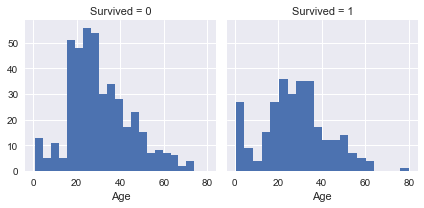

In [119]:
grid = sns.FacetGrid(training, col='Survived')
grid.map(plt.hist, 'Age', bins=20);

- Looking at barchart of Age-vs-Survived we can see peak in survival at very your age suggesting that childen were first to board on survival boats.

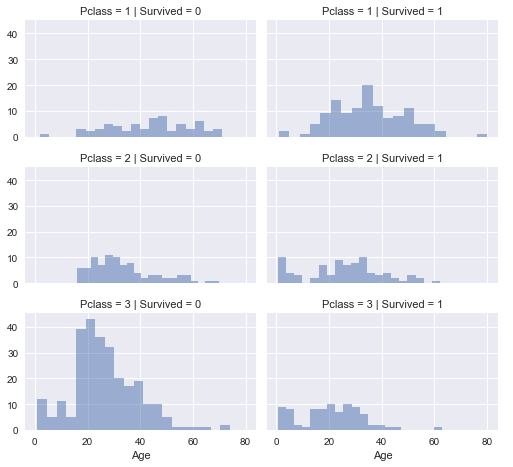

In [120]:
grid = sns.FacetGrid(training, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

- Pclass/Age-vs-Survived shows that 3rd class passengers had less chances of survival than the rest.

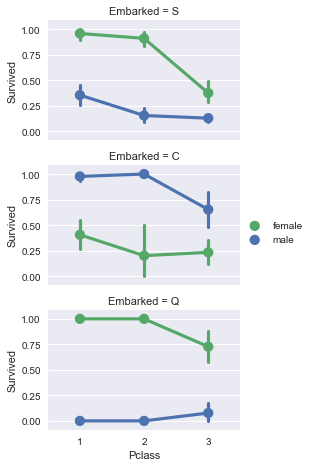

In [121]:
grid = sns.FacetGrid(training, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend();

- Pclass/Sex-vs-Survivability confirms that 3rd class had less chances to survive;
- we also see that 1st class females embarked in S and Q have a lot higher chances to survive than women embarked in C.

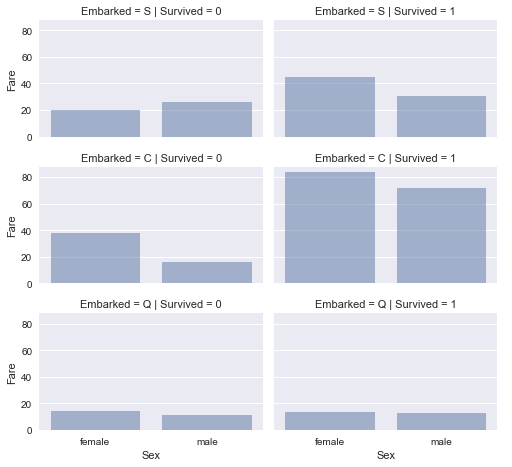

In [122]:
grid = sns.FacetGrid(training, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend();

- Overall trend is showing that people who paid more (Fare) had higher chance to survive.

### Feature creation:

Let's create a feature to divide Age by mising values:

In [123]:
for dataset in combine:
    dataset['copyAge'] = dataset.Age
    dataset['isAge'] = dataset.Age.fillna(0)
    dataset.isAge = dataset.isAge[dataset.isAge!=0].astype(int).astype(str).replace(regex={'\d+': '1'})
    dataset.isAge.fillna(0,inplace=True)

In [124]:
#training.isAge = training.isAge[training.isAge!=0].astype(int).astype(str).replace(regex={'\d+': '1'})

In [125]:
#training.isAge.fillna(0,inplace=True)

In [126]:
check_survived('isAge')

isAge  Survived           
             mean  sum count
1     1  0.406162  290   714
0     0  0.293785   52   177

Additional maybe we create Family Size:

In [127]:
for dataset in combine:
    dataset['Family'] = dataset.SibSp + dataset.Parch + 1

In [128]:
check_survived('Family')

Family  Survived           
              mean  sum count
3      4  0.724138   21    29
2      3  0.578431   59   102
1      2  0.552795   89   161
6      7  0.333333    4    12
0      1  0.303538  163   537
4      5  0.200000    3    15
5      6  0.136364    3    22
7      8  0.000000    0     6
8     11  0.000000    0     7

Check if somene is alone:

In [129]:
for dataset in combine:
    dataset['Alone'] = dataset.Family
    dataset.Alone.replace(range(2,12),0,inplace=True)

In [130]:
#training.Alone.replace(range(2,12),0,inplace=True)

In [131]:
check_survived('Alone')

Alone  Survived           
             mean  sum count
0     0  0.505650  179   354
1     1  0.303538  163   537

Now maybe we categorize family better:

In [132]:
for dataset in combine:
    dataset['FamSize'] = dataset.Family
    dataset.FamSize = pd.cut(dataset.Family,[0,1,3,4,12]).apply(lambda row: row.right).map({1:0,3:1,4:2,12:3})

#training['FamSize'] = training.Family

In [133]:
#training.FamSize = pd.cut(training.Family,[0,1,3,4,12]).apply(lambda row: row.right).map({1:0,3:1,4:2,12:3})

In [134]:
check_survived('FamSize')

FamSize  Survived           
               mean  sum count
2       2  0.724138   21    29
1       1  0.562738  148   263
0       0  0.303538  163   537
3       3  0.161290   10    62

And ticket type:

In [135]:
for dataset in combine:
    dataset['Ttype'] = dataset.Ticket.str.extract('(\w)\.*', expand=False).replace(regex={'\d': 0}).replace(regex={'\D': 1}).astype(int)
    #dataset['Ttype'] = dataset.Ticket.str.findall(r'(\w{1})\.*').str.get(0)
    
pd.crosstab(training['Ttype'], training['Survived'])

Survived,0,1
Ttype,,
0,407,254
1,142,88


In [136]:
check_survived('Ttype',sort='Ttype')

Ttype  Survived           
             mean  sum count
1     1  0.382609   88   230
0     0  0.384266  254   661

In [137]:
#pd.crosstab(training['Fare'], training['Pclass'])

Considering title from name column we can extract it and test hypothesis suggesting that important and wealthy person had higher chance to survive.

In [138]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(training['Title'], training['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


We see that there are titles that are very rare so we will combine them into one category. In addition we clean misspelling for "Miss" and "Mrs".

In [139]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                                 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
check_survived('Title')

Title  Survived           
               mean  sum count
3     Mrs  0.793651  100   126
1    Miss  0.702703  130   185
0  Master  0.575000   23    40
4    Rare  0.347826    8    23
2      Mr  0.156673   81   517

- It's visible that titled person have very significant chance to survive.

Now we will map titles to digits for further analysis.

In [140]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

training.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,1,2,0,1,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,1,2,0,1,1,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,1,1,1,0,1,2


Similar mapping process need to be done on Sex column.

In [141]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

training.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,1,2,0,1,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,38.0,1,2,0,1,1,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,1,1,1,0,1,2


There is significant amount of null values (19,9%) in Age column and we do not want to reduce our training data. In conclusion we will use median of age of passengers from the same Sex and Pclass.

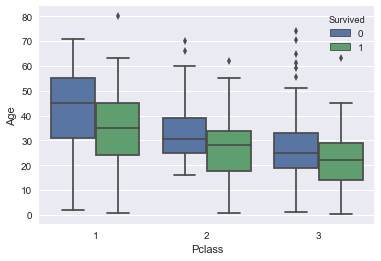

In [142]:
foo = sns.boxplot(x="Pclass", y="Age", hue="Survived", data=training)

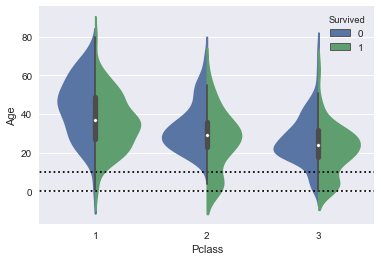

In [143]:
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=training, split=True)
plt.hlines([0,10], xmin=-1, xmax=3, linestyles="dotted")

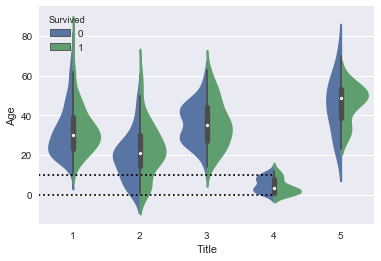

In [144]:
sns.violinplot(x="Title", y="Age", hue="Survived", data=training, split=True)
plt.hlines([0,10], xmin=-1, xmax=3, linestyles="dotted")

In [145]:
def check_age(column):
    result = training[[column, 'Age']].groupby([column], as_index=False).agg({'Age':['mean','median','count']})\
    .sort_values(by=[column], ascending=False)
    return result

In [146]:
check_age('Title')

Title        Age             
              mean median count
4     5  45.545455   48.5    22
3     4   4.574167    3.5    36
2     3  35.788991   35.0   109
1     2  21.845638   21.0   149
0     1  32.368090   30.0   398

In [147]:
check_age('Pclass')

Pclass        Age             
               mean median count
2      3  25.140620   24.0   355
1      2  29.877630   29.0   173
0      1  38.233441   37.0   186

In [148]:
check_age('Sex')

Sex        Age             
            mean median count
1   1  27.915709   27.0   261
0   0  30.726645   29.0   453

In [149]:
def check_age(column,column2,column3):
    result = training[[column, column2,column3, 'Age']].groupby([column,column2,column3], as_index=False).agg({'Age':['mean','median','count']})\
    .sort_values(by=[column], ascending=False)
    return result
check_age('Title','Pclass','Sex')

Title Pclass Sex        Age             
                          mean median count
12     5      1   0  48.727273   49.0    11
13     5      1   1  43.333333   48.0     3
14     5      2   0  42.000000   46.5     8
9      4      1   0   5.306667    4.0     3
10     4      2   0   2.258889    1.0     9
11     4      3   0   5.350833    4.0    24
6      3      1   1  40.400000   40.0    35
7      3      2   1  33.682927   32.0    41
8      3      3   1  33.515152   31.0    33
3      2      1   1  29.744681   30.0    47
4      2      2   1  22.560606   24.0    33
5      2      3   1  16.123188   18.0    69
0      1      1   0  41.580460   40.0    87
1      1      2   0  32.768293   31.0    82
2      1      3   0  28.724891   26.0   229

In [150]:
Title = training[['Age','Title']].groupby(['Title']).median()
Title2 = np.round(training[['Age','Title']].groupby(['Title']).mean())

pd.concat([Title,Title2],axis=1)

,Age,Age
Title,,
1,30.0,32.0
2,21.0,22.0
3,35.0,36.0
4,3.5,5.0
5,48.5,46.0


In [151]:
Pclass = training[['Age','Pclass']].groupby(['Pclass']).median()
Pclass2 = np.round(training[['Age','Pclass']].groupby(['Pclass']).mean())

pd.concat([Pclass,Pclass2],axis=1)

,Age,Age
Pclass,,
1,37.0,38.0
2,29.0,30.0
3,24.0,25.0


guess_ages = np.zeros((2,3))
guess_ages

##Zrob to na groupby!!!
##Boxploty dla wieku w grupach


for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

training.head(3)

grid = sns.FacetGrid(training, col='Survived')
grid.map(plt.hist, 'Age', bins=20);

In [152]:
guess_ages = np.zeros((2,3,5))
guess_ages

array([[[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]]])

In [153]:
##Zrob to na groupby!!!
##Boxploty dla wieku w grupach


for dataset in combine:
    for i in range(0,2):
        for j in range(0,3):
            for k in range(0,5):
                guess_df = dataset[#(dataset['Sex'] == i) & \
                                   #(dataset['Pclass'] == j+1) &\
                                   (dataset['Title'] == k+1)\
                                    ]['Age'].dropna()
                #print(guess_df.unique())
                age_guess = guess_df.median()
                #print(age_guess)
                # Convert random age float to nearest .5 age
                guess_ages[i,j,k] = int( age_guess/0.5 + 0.5 ) * 0.5

    for i in range(0, 2):
        for j in range(0, 3):
             for k in range(0,5):                       
                dataset.loc[(dataset.Age.isnull()) &\
                            #(dataset.Sex == i) &\
                            #(dataset.Pclass == j+1) &\
                            (dataset.Title == k+1),\
                            'Age'] = guess_ages[i,j,k]

    dataset['Age'] = dataset['Age'].astype(int)

training.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,S,22.0,1,2,0,1,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,C,38.0,1,2,0,1,1,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,1,1,1,0,1,2


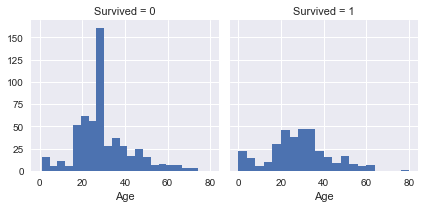

In [154]:
grid = sns.FacetGrid(training, col='Survived')
grid.map(plt.hist, 'Age', bins=20);

We will group Age values into bins. Below we split passengers into 8 bins and show survival rate.

In [155]:
training['AgeBand'] = pd.cut(training['Age'], 8)
check_survived('AgeBand')

AgeBand  Survived           
                      mean  sum count
0  (-0.08, 10.0]  0.588235   40    68
3   (30.0, 40.0]  0.482558   83   172
5   (50.0, 60.0]  0.404762   17    42
4   (40.0, 50.0]  0.388235   33    85
1   (10.0, 20.0]  0.379310   44   116
2   (20.0, 30.0]  0.310881  120   386
7   (70.0, 80.0]  0.250000    1     4
6   (60.0, 70.0]  0.222222    4    18

In [156]:
AgeBands = np.append(-1,training.AgeBand.apply(lambda x: x.right).unique().sort_values().astype(int))
AgeBands

array([-1, 10, 20, 30, 40, 50, 60, 70, 80])

In [157]:
testing['AgeBand'] = pd.cut(testing['Age'],AgeBands)

In [158]:
AgeKeys = AgeBands[1:]
AgeValues = range(0,8)
age_map = dict(zip(AgeKeys, AgeValues))

In [159]:
training.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title,AgeBand
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,S,22.0,1,2,0,1,1,1,"(20.0, 30.0]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,C,38.0,1,2,0,1,1,3,"(30.0, 40.0]"
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,1,1,1,0,1,2,"(20.0, 30.0]"


In [160]:
testing.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title,AgeBand
0,892,3,"Kelly, Mr. James",0,34,0,0,330911,7.8292,NaN,Q,34.5,1,1,1,0,0,1,"(30, 40]"
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47,1,0,363272,7.0000,NaN,S,47.0,1,2,0,1,0,3,"(40, 50]"
2,894,2,"Myles, Mr. Thomas Francis",0,62,0,0,240276,9.6875,NaN,Q,62.0,1,1,1,0,0,1,"(60, 70]"


Now we map age-ranges with numeric code as shown below:

In [161]:
combine = [training, testing] 

for dataset in combine:
    dataset['Age'] = dataset['AgeBand'].apply(lambda row: row.right).map(age_map).astype(int)

training = training.drop(['AgeBand'], axis=1)
testing = testing.drop(['AgeBand'], axis=1)

combine = [training, testing]    
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,2,1,0,A/5 21171,7.2500,NaN,S,22.0,1,2,0,1,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3,1,0,PC 17599,71.2833,C85,C,38.0,1,2,0,1,1,3
2,3,1,3,"Heikkinen, Miss. Laina",1,2,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,1,1,1,0,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3,1,0,113803,53.1000,C123,S,35.0,1,2,0,1,0,3
4,5,0,3,"Allen, Mr. William Henry",0,3,0,0,373450,8.0500,NaN,S,35.0,1,1,1,0,0,1


We do not need our temporary column "AgeBand", so it was removed.

Embarkation feature contains a few missing values so we will fill them with most common value among data.

In [162]:
freq_port = training.Embarked.dropna().mode()[0]
freq_port

'S'

In [163]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
check_survived('Embarked')

Embarked  Survived           
                mean  sum count
0        C  0.553571   93   168
1        Q  0.389610   30    77
2        S  0.339009  219   646

We can see that people embarked in C had higher chances to survive.

Now we can map Embarked feature to digit values.

In [164]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,2,1,0,A/5 21171,7.2500,NaN,0,22.0,1,2,0,1,1,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3,1,0,PC 17599,71.2833,C85,1,38.0,1,2,0,1,1,3
2,3,1,3,"Heikkinen, Miss. Laina",1,2,0,0,STON/O2. 3101282,7.9250,NaN,0,26.0,1,1,1,0,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3,1,0,113803,53.1000,C123,0,35.0,1,2,0,1,0,3
4,5,0,3,"Allen, Mr. William Henry",0,3,0,0,373450,8.0500,NaN,0,35.0,1,1,1,0,0,1


There is one missing value in Fare feature in testing dataset that we can easily replace with median value.

In [165]:
for dataset in combine:
    dataset['copyFare'] = dataset.Fare


testing['Fare'].fillna(testing['Fare'].dropna().median(), inplace=True)
testing.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title,copyFare
0,892,3,"Kelly, Mr. James",0,3,0,0,330911,7.8292,NaN,2,34.5,1,1,1,0,0,1,7.8292
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,4,1,0,363272,7.0000,NaN,0,47.0,1,2,0,1,0,3,7.0000
2,894,2,"Myles, Mr. Thomas Francis",0,6,0,0,240276,9.6875,NaN,2,62.0,1,1,1,0,0,1,9.6875
3,895,3,"Wirz, Mr. Albert",0,2,0,0,315154,8.6625,NaN,0,27.0,1,1,1,0,0,1,8.6625
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,2,1,1,3101298,12.2875,NaN,0,22.0,1,3,0,1,0,3,12.2875


### Let's crosscheck Fare with Pclass:

In [166]:
testing[['Pclass','Fare']].groupby('Pclass').agg({'Fare':['min','median','mean','max','count']})

Fare                                    
           min   median       mean       max count
Pclass                                            
1       0.0000  60.0000  94.280297  512.3292   107
2       9.6875  15.7500  22.202104   73.5000    93
3       3.1708   7.8958  12.468827   69.5500   218

In [167]:
training[['Pclass','Fare']].groupby('Pclass').agg({'Fare':['min','median','mean','max','count']})

Fare                                    
        min   median       mean       max count
Pclass                                         
1       0.0  60.2875  84.154687  512.3292   216
2       0.0  14.2500  20.662183   73.5000   184
3       0.0   8.0500  13.675550   69.5500   491

In [168]:
training[training.Pclass==1].sort_values(by='Fare')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title,copyFare
633,634,0,1,"Parr, Mr. William Henry Marsh",0,2,0,0,112052,0.0000,NaN,0,NaN,0,1,1,0,0,1,0.0000
822,823,0,1,"Reuchlin, Jonkheer. John George",0,3,0,0,19972,0.0000,NaN,0,38.00,1,1,1,0,0,5,0.0000
815,816,0,1,"Fry, Mr. Richard",0,2,0,0,112058,0.0000,B102,0,NaN,0,1,1,0,0,1,0.0000
806,807,0,1,"Andrews, Mr. Thomas Jr",0,3,0,0,112050,0.0000,A36,0,39.00,1,1,1,0,0,1,0.0000
263,264,0,1,"Harrison, Mr. William",0,3,0,0,112059,0.0000,B94,0,40.00,1,1,1,0,0,1,0.0000
872,873,0,1,"Carlsson, Mr. Frans Olof",0,3,0,0,695,5.0000,B51 B53 B55,0,33.00,1,1,1,0,0,1,5.0000
662,663,0,1,"Colley, Mr. Edward Pomeroy",0,4,0,0,5727,25.5875,E58,0,47.00,1,1,1,0,0,1,25.5875
168,169,0,1,"Baumann, Mr. John D",0,2,0,0,PC 17318,25.9250,NaN,0,NaN,0,1,1,0,1,1,25.9250
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",1,4,0,0,17466,25.9292,D17,0,48.00,1,1,1,0,0,3,25.9292
796,797,1,1,"Leader, Dr. Alice (Farnham)",1,4,0,0,17465,25.9292,D17,0,49.00,1,1,1,0,0,5,25.9292


In [169]:
training[training.Pclass==2].sort_values(by='Fare')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title,copyFare
466,467,0,2,"Campbell, Mr. William",0,2,0,0,239853,0.0000,NaN,0,NaN,0,1,1,0,0,1,0.0000
732,733,0,2,"Knight, Mr. Robert J",0,2,0,0,239855,0.0000,NaN,0,NaN,0,1,1,0,0,1,0.0000
674,675,0,2,"Watson, Mr. Ennis Hastings",0,2,0,0,239856,0.0000,NaN,0,NaN,0,1,1,0,0,1,0.0000
413,414,0,2,"Cunningham, Mr. Alfred Fleming",0,2,0,0,239853,0.0000,NaN,0,NaN,0,1,1,0,0,1,0.0000
277,278,0,2,"Parkes, Mr. Francis ""Frank""",0,2,0,0,239853,0.0000,NaN,0,NaN,0,1,1,0,0,1,0.0000
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",0,2,0,0,239854,0.0000,NaN,0,NaN,0,1,1,0,0,1,0.0000
812,813,0,2,"Slemen, Mr. Richard James",0,3,0,0,28206,10.5000,NaN,0,35.00,1,1,1,0,0,1,10.5000
772,773,0,2,"Mack, Mrs. (Mary)",1,5,0,0,S.O./P.P. 3,10.5000,E77,0,57.00,1,1,1,0,1,3,10.5000
265,266,0,2,"Reeves, Mr. David",0,3,0,0,C.A. 17248,10.5000,NaN,0,36.00,1,1,1,0,1,1,10.5000
458,459,1,2,"Toomey, Miss. Ellen",1,4,0,0,F.C.C. 13531,10.5000,NaN,0,50.00,1,1,1,0,1,2,10.5000


In [170]:
training[training.Pclass==3].sort_values(by='Fare')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title,copyFare
302,303,0,3,"Johnson, Mr. William Cahoone Jr",0,1,0,0,LINE,0.0000,NaN,0,19.0,1,1,1,0,1,1,0.0000
271,272,1,3,"Tornquist, Mr. William Henry",0,2,0,0,LINE,0.0000,NaN,0,25.0,1,1,1,0,1,1,0.0000
597,598,0,3,"Johnson, Mr. Alfred",0,4,0,0,LINE,0.0000,NaN,0,49.0,1,1,1,0,1,1,0.0000
179,180,0,3,"Leonard, Mr. Lionel",0,3,0,0,LINE,0.0000,NaN,0,36.0,1,1,1,0,1,1,0.0000
378,379,0,3,"Betros, Mr. Tannous",0,1,0,0,2648,4.0125,NaN,1,20.0,1,1,1,0,0,1,4.0125
326,327,0,3,"Nysveen, Mr. Johan Hansen",0,6,0,0,345364,6.2375,NaN,0,61.0,1,1,1,0,0,1,6.2375
843,844,0,3,"Lemberopolous, Mr. Peter L",0,3,0,0,2683,6.4375,NaN,1,34.5,1,1,1,0,0,1,6.4375
818,819,0,3,"Holm, Mr. John Fredrik Alexander",0,4,0,0,C 7075,6.4500,NaN,0,43.0,1,1,1,0,1,1,6.4500
371,372,0,3,"Wiklund, Mr. Jakob Alfred",0,1,1,0,3101267,6.4958,NaN,0,18.0,1,2,0,1,0,1,6.4958
202,203,0,3,"Johanson, Mr. Jakob Alfred",0,3,0,0,3101264,6.4958,NaN,0,34.0,1,1,1,0,0,1,6.4958


Let's group Fare feature into ranges and check agains survived column.

In [171]:

training['FareBand'] = pd.qcut(training['Fare'], 6)
check_survived('FareBand')

FareBand  Survived           
                          mean  sum count
5  (52.369, 512.329]  0.697987  104   149
3     (14.454, 26.0]  0.436242   65   149
4     (26.0, 52.369]  0.417808   61   146
2    (8.662, 14.454]  0.366906   51   139
0    (-0.001, 7.775]  0.205128   32   156
1     (7.775, 8.662]  0.190789   29   152

In [172]:
FareBands = np.append(-1,training.FareBand.apply(lambda x: x.right).unique().sort_values().astype(float))
FareBands

array([  -1.   ,    7.775,    8.662,   14.454,   26.   ,   52.369,  512.329])

In [173]:
FareKeys = FareBands[1:]
FareValues = range(0,6)
fare_map = dict(zip(FareKeys, FareValues))
fare_map

{7.7750000000000004: 0,
 8.6620000000000008: 1,
 14.454000000000001: 2,
 26.0: 3,
 52.369: 4,
 512.32899999999995: 5}

In [174]:
testing['FareBand'] = pd.cut(testing['Fare'],FareBands).fillna(training.FareBand.unique().sort_values()[5])

Using ranges above we can now split Fare feature and code to digits.

In [175]:
combine = [training, testing]

for dataset in combine:
    dataset['Fare'] = dataset['FareBand'].apply(lambda row: row.right).map(fare_map).astype(int)

training = training.drop(['FareBand'], axis=1)
testing = testing.drop(['FareBand'], axis=1)

combine = [training, testing]    
training.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title,copyFare
0,1,0,3,"Braund, Mr. Owen Harris",0,2,1,0,A/5 21171,0,NaN,0,22.0,1,2,0,1,1,1,7.2500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3,1,0,PC 17599,5,C85,1,38.0,1,2,0,1,1,3,71.2833
2,3,1,3,"Heikkinen, Miss. Laina",1,2,0,0,STON/O2. 3101282,1,NaN,0,26.0,1,1,1,0,1,2,7.9250
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3,1,0,113803,5,C123,0,35.0,1,2,0,1,0,3,53.1000
4,5,0,3,"Allen, Mr. William Henry",0,3,0,0,373450,1,NaN,0,35.0,1,1,1,0,0,1,8.0500
5,6,0,3,"Moran, Mr. James",0,2,0,0,330877,1,NaN,2,NaN,0,1,1,0,0,1,8.4583
6,7,0,1,"McCarthy, Mr. Timothy J",0,5,0,0,17463,4,E46,0,54.0,1,1,1,0,0,1,51.8625
7,8,0,3,"Palsson, Master. Gosta Leonard",0,0,3,1,349909,3,NaN,0,2.0,1,5,0,3,0,4,21.0750
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,2,0,2,347742,2,NaN,0,27.0,1,3,0,1,0,3,11.1333
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,1,1,0,237736,4,NaN,1,14.0,1,2,0,1,0,3,30.0708


We do have a lot of missing data in Cabin feature. We will treat this as passengers without cabins and create another value for cabin feature.

In [176]:
for dataset in combine:
    dataset.Cabin.fillna('No_Cabin', inplace=True)

Let's inspect what values are hidden inside Cabin column.

In [177]:
np.sort(training.Cabin.unique())

array(['A10', 'A14', 'A16', 'A19', 'A20', 'A23', 'A24', 'A26', 'A31',
       'A32', 'A34', 'A36', 'A5', 'A6', 'A7', 'B101', 'B102', 'B18', 'B19',
       'B20', 'B22', 'B28', 'B3', 'B30', 'B35', 'B37', 'B38', 'B39', 'B4',
       'B41', 'B42', 'B49', 'B5', 'B50', 'B51 B53 B55', 'B57 B59 B63 B66',
       'B58 B60', 'B69', 'B71', 'B73', 'B77', 'B78', 'B79', 'B80',
       'B82 B84', 'B86', 'B94', 'B96 B98', 'C101', 'C103', 'C104', 'C106',
       'C110', 'C111', 'C118', 'C123', 'C124', 'C125', 'C126', 'C128',
       'C148', 'C2', 'C22 C26', 'C23 C25 C27', 'C30', 'C32', 'C45', 'C46',
       'C47', 'C49', 'C50', 'C52', 'C54', 'C62 C64', 'C65', 'C68', 'C7',
       'C70', 'C78', 'C82', 'C83', 'C85', 'C86', 'C87', 'C90', 'C91',
       'C92', 'C93', 'C95', 'C99', 'D', 'D10 D12', 'D11', 'D15', 'D17',
       'D19', 'D20', 'D21', 'D26', 'D28', 'D30', 'D33', 'D35', 'D36',
       'D37', 'D45', 'D46', 'D47', 'D48', 'D49', 'D50', 'D56', 'D6', 'D7',
       'D9', 'E10', 'E101', 'E12', 'E121', 'E17', 'E24',

We will extract letter into new Sector feature and Cabin number into numbers that would be converted into range.

In [178]:
for dataset in combine:
    dataset['Cabin_has'] = dataset.Cabin.str.findall(r'(\w{1})\d{2}').str.get(0).replace(regex={'\D': 1}).fillna(0).astype(int)
    dataset['Cabin_sector'] = dataset.Cabin.str.findall(r'(\w{1})\d{2}').str.get(0)
    dataset['Cabin_number'] = dataset.Cabin.str.findall(r'\w{1}(\d{2,3})').str.get(0).fillna(0).astype(int)
    dataset.Cabin_sector.fillna('0', inplace=True)

training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,isAge,Family,Alone,FamSize,Ttype,Title,copyFare,Cabin_has,Cabin_sector,Cabin_number
0,1,0,3,"Braund, Mr. Owen Harris",0,2,1,0,A/5 21171,0,...,1,2,0,1,1,1,7.2500,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3,1,0,PC 17599,5,...,1,2,0,1,1,3,71.2833,1,C,85
2,3,1,3,"Heikkinen, Miss. Laina",1,2,0,0,STON/O2. 3101282,1,...,1,1,1,0,1,2,7.9250,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3,1,0,113803,5,...,1,2,0,1,0,3,53.1000,1,C,123
4,5,0,3,"Allen, Mr. William Henry",0,3,0,0,373450,1,...,1,1,1,0,0,1,8.0500,0,0,0


In [179]:
check_survived('Cabin_has')

Cabin_has  Survived           
                 mean  sum count
1         1  0.664773  117   176
0         0  0.314685  225   715

I was thinking that FIrst class must have Cabin

In [180]:
training.loc[(training.Pclass==1), 'Cabin_has'].value_counts()

1    160
0     56
Name: Cabin_has, dtype: int64

In [181]:
training.loc[(training.Pclass==1), 'Cabin_has'] = 1

In [182]:
check_survived('Cabin_has')

Cabin_has  Survived           
                 mean  sum count
1         1  0.633621  147   232
0         0  0.295903  195   659

Let's check if Cabin number and sector have impact on survival rate by creating ranges of numbers:

In [183]:
training['CabinBand'] = pd.cut(training['Cabin_number'], 7)
check_survived('CabinBand')

CabinBand  Survived           
                           mean  sum count
4   (84.571, 105.714]  0.720000   18    25
1    (21.143, 42.286]  0.666667   36    54
2    (42.286, 63.429]  0.636364   21    33
3    (63.429, 84.571]  0.576923   15    26
5  (105.714, 126.857]  0.571429    8    14
6    (126.857, 148.0]  0.500000    1     2
0    (-0.148, 21.143]  0.329715  243   737

In [184]:
CabinBands = np.append(-1,training.CabinBand.apply(lambda x: x.right).unique().sort_values().astype(float))
CabinBands

CabinKeys = CabinBands[1:]
CabinValues = range(0,7)
cabin_map = dict(zip(CabinKeys, CabinValues))
cabin_map

testing['CabinBand'] = pd.cut(testing['Cabin_number'],CabinBands)#.fillna(training.CabinBand.unique().sort_values()[5])

In [185]:
check_survived('Cabin_sector')

Cabin_sector  Survived           
                    mean  sum count
4            D  0.777778   21    27
6            F  0.750000    3     4
5            E  0.741935   23    31
2            B  0.720930   31    43
3            C  0.589286   33    56
1            A  0.500000    6    12
0            0  0.314685  225   715
7            G  0.000000    0     3

In [186]:
training[['Cabin_sector','Survived','Pclass']].groupby(['Pclass','Cabin_sector'], as_index=False)\
.agg({'Survived':['mean','sum','count']})

Pclass Cabin_sector  Survived           
                            mean  sum count
0       1            0  0.535714   30    56
1       1            A  0.500000    6    12
2       1            B  0.720930   31    43
3       1            C  0.589286   33    56
4       1            D  0.769231   20    26
5       1            E  0.695652   16    23
6       2            0  0.454545   80   176
7       2            D  1.000000    1     1
8       2            E  0.750000    3     4
9       2            F  1.000000    3     3
10      3            0  0.238095  115   483
11      3            E  1.000000    4     4
12      3            F  0.000000    0     1
13      3            G  0.000000    0     3

In [187]:
training[['Cabin_sector','Survived','Pclass','copyFare']].groupby(['Pclass','Cabin_sector'], as_index=False)\
.agg({'Survived':['mean','sum','count'],'copyFare':['min','mean','median','max']})

Pclass Cabin_sector  Survived            copyFare                        \
                            mean  sum count      min        mean    median   
0       1            0  0.535714   30    56   0.0000   79.682363  50.75210   
1       1            A  0.500000    6    12   0.0000   41.125692  39.86250   
2       1            B  0.720930   31    43   0.0000  108.675293  79.20000   
3       1            C  0.589286   33    56  26.5500  100.193971  86.28960   
4       1            D  0.769231   20    26  25.9292   63.480296  69.30415   
5       1            E  0.695652   16    23  25.5875   55.969748  55.00000   
6       2            0  0.454545   80   176   0.0000   21.070976  15.04790   
7       2            D  1.000000    1     1  13.0000   13.000000  13.00000   
8       2            E  0.750000    3     4  10.5000   11.587500  11.42500   
9       2            F  1.000000    3     3  10.5000   11.333333  10.50000   
10      3            0  0.238095  115   483   0.0000   13.723886   8.05000   
11      3            E  1.000000    4     4   8.0500   13.839575  12.47500   
12      3            F  0.000000    0     1   7.7500    7.750000   7.75000   
13      3            G  0.000000    0     3   7.6500    7.650000   7.65000   

              
         max  
0   512.3292  
1    81.8583  
2   512.3292  
3   263.0000  
4   113.2750  
5   134.5000  
6    73.5000  
7    13.0000  
8    13.0000  
9    13.0000  
10   69.5500  
11   22.3583  
12    7.7500  
13    7.6500

In [188]:
training[['Cabin_sector','copyFare']].groupby(['Cabin_sector'], as_index=False)\
.agg({'copyFare':['min','mean','median','max','count']})

Cabin_sector copyFare                                     
                    min        mean   median       max count
0            0     0.00   20.698379  11.5000  512.3292   715
1            A     0.00   41.125692  39.8625   81.8583    12
2            B     0.00  108.675293  79.2000  512.3292    43
3            C    26.55  100.193971  86.2896  263.0000    56
4            D    13.00   61.610656  63.3583  113.2750    27
5            E     8.05   44.806855  26.5500  134.5000    31
6            F     7.75   10.437500  10.5000   13.0000     4
7            G     7.65    7.650000   7.6500    7.6500     3

In [189]:
testing[['Cabin_sector','copyFare']].groupby(['Cabin_sector'], as_index=False)\
.agg({'copyFare':['min','mean','median','max','count']})

Cabin_sector copyFare                                      
                    min        mean    median       max count
0            0   0.0000   19.943886  12.35000  262.3750   336
1            A  27.7208   47.219433  31.08960   81.8583     6
2            B   0.0000  145.562733  87.88335  512.3292    18
3            C  25.7000  122.525656  98.21250  263.0000    32
4            D  13.8625   44.518400  45.63125   76.2917    12
5            E   7.2292   70.795836  61.17500  134.5000    11
6            F  10.5000   10.500000  10.50000   10.5000     1
7            G   7.6500    7.650000   7.65000    7.6500     1

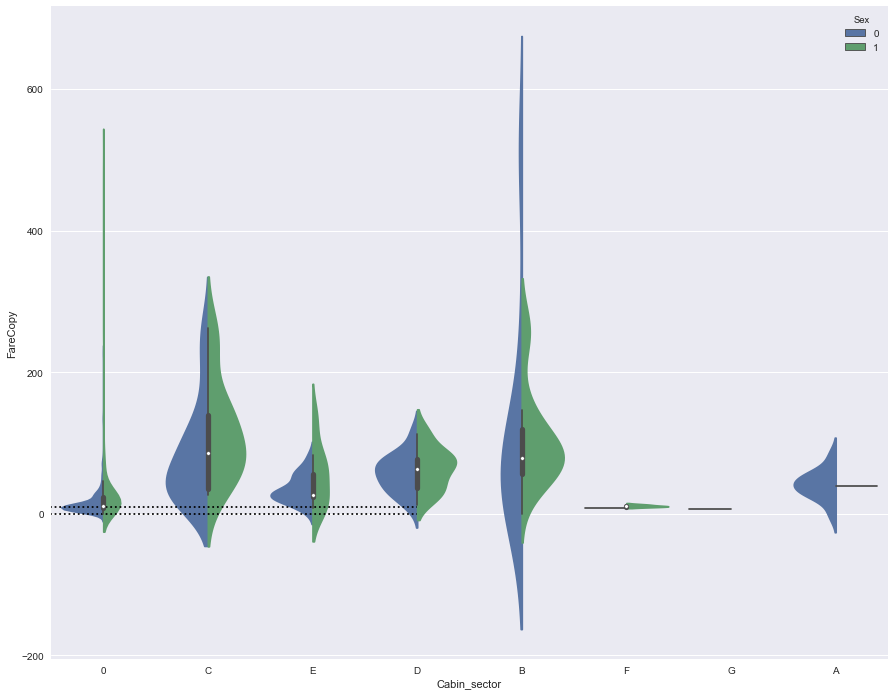

In [102]:
f, ax = plt.subplots(figsize=(15, 12))
sns.violinplot(x="Cabin_sector", y="copyFare", hue="Sex", data=training, split=True,ax=ax)
plt.hlines([0,10], xmin=-1, xmax=3, linestyles="dotted")

We see that Sector G and category '0' (no Cabin) has a lot less survival rate than other cabins.

In [460]:
combine = [training, testing]

for dataset in combine:
    dataset['Cabin_number'] = dataset['CabinBand'].apply(lambda row: row.right).map(cabin_map).astype(int)

training = training.drop(['CabinBand'], axis=1)
testing = testing.drop(['CabinBand'], axis=1)
    
combine = [training, testing]
    
training.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,copyAge,isAge,Family,Alone,FamSize,Ttype,Title,Cabin_has,Cabin_sector,Cabin_number
0,1,0,3,"Braund, Mr. Owen Harris",0,2,1,0,A/5 21171,0,...,22.0,1,2,0,1,1,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3,1,0,PC 17599,5,...,38.0,1,2,0,1,1,3,1,C,4
2,3,1,3,"Heikkinen, Miss. Laina",1,2,0,0,STON/O2. 3101282,1,...,26.0,1,1,1,0,1,2,0,0,0


We can now convert Cabin Sector to numeric values and drop unnecessary columns.

In [461]:
SectorKeys = np.append(0,sorted(training.Cabin_sector.unique()[1:]))
#SectorKeys

SectorValues = range(0,8)
sector_map = dict(zip(SectorKeys, SectorValues))
sector_map

{'0': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

In [462]:
combine = [training, testing]

for dataset in combine:
    dataset['Cabin_sector'] = dataset['Cabin_sector'].map(sector_map).astype(int)
    
combine = [training, testing]
    
training.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,copyAge,isAge,Family,Alone,FamSize,Ttype,Title,Cabin_has,Cabin_sector,Cabin_number
0,1,0,3,"Braund, Mr. Owen Harris",0,2,1,0,A/5 21171,0,...,22.0,1,2,0,1,1,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3,1,0,PC 17599,5,...,38.0,1,2,0,1,1,3,1,3,4
2,3,1,3,"Heikkinen, Miss. Laina",1,2,0,0,STON/O2. 3101282,1,...,26.0,1,1,1,0,1,2,0,0,0


In [463]:
for dataset in combine:
    dataset.drop(['Cabin','Name','Ticket'], axis=1, inplace=True)
    
training.head(3)    

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title,Cabin_has,Cabin_sector,Cabin_number
0,1,0,3,0,2,1,0,0,0,22.0,1,2,0,1,1,1,0,0,0
1,2,1,1,1,3,1,0,5,1,38.0,1,2,0,1,1,3,1,3,4
2,3,1,3,1,2,0,0,1,0,26.0,1,1,1,0,1,2,0,0,0


In [464]:
testing.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,copyAge,isAge,Family,Alone,FamSize,Ttype,Title,Cabin_has,Cabin_sector,Cabin_number
0,892,3,0,3,0,0,1,2,34.5,1,1,1,0,0,1,0,0,0
1,893,3,1,4,1,0,0,0,47.0,1,2,0,1,0,3,0,0,0
2,894,2,0,6,0,0,2,2,62.0,1,1,1,0,0,1,0,0,0


All features are now converted to categories with numerical values

Let's check all features if there is no missing values or any other things left to fix.

In [465]:
training.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,copyAge,Family,Alone,FamSize,Ttype,Title,Cabin_has,Cabin_sector,Cabin_number
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,2.345679,0.523008,0.381594,2.475870,0.361392,29.699118,1.904602,0.602694,0.569024,0.258137,1.728395,0.260382,0.644220,0.426487
std,257.353842,0.486592,0.836071,0.477990,1.323738,1.102743,0.806057,1.724976,0.635673,14.526497,1.613459,0.489615,0.853614,0.437855,1.030039,0.439089,1.428529,1.101549
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.420000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,20.125000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,28.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,3.000000,1.000000,0.000000,4.000000,1.000000,38.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000
max,891.000000,1.000000,3.000000,1.000000,7.000000,8.000000,6.000000,5.000000,2.000000,80.000000,11.000000,1.000000,3.000000,1.000000,5.000000,1.000000,7.000000,6.000000


In [466]:
testing.describe()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,copyAge,Family,Alone,FamSize,Ttype,Title,Cabin_has,Cabin_sector,Cabin_number
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,0.363636,2.385167,0.447368,0.392344,2.476077,0.464115,30.272590,1.839713,0.605263,0.523923,0.291866,1.741627,0.193780,0.607656,0.375598
std,120.810458,0.841838,0.481622,1.289124,0.896760,0.981429,1.739829,0.685516,14.181209,1.519072,0.489380,0.777780,0.455166,1.006091,0.395732,1.353258,0.986760
min,892.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,21.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1100.500000,3.000000,0.000000,2.000000,0.000000,0.000000,3.000000,0.000000,27.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1204.750000,3.000000,1.000000,3.000000,1.000000,0.000000,4.000000,1.000000,39.000000,2.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000
max,1309.000000,3.000000,1.000000,7.000000,8.000000,9.000000,5.000000,2.000000,76.000000,11.000000,1.000000,3.000000,1.000000,5.000000,1.000000,7.000000,6.000000


#### Pearson Correlation

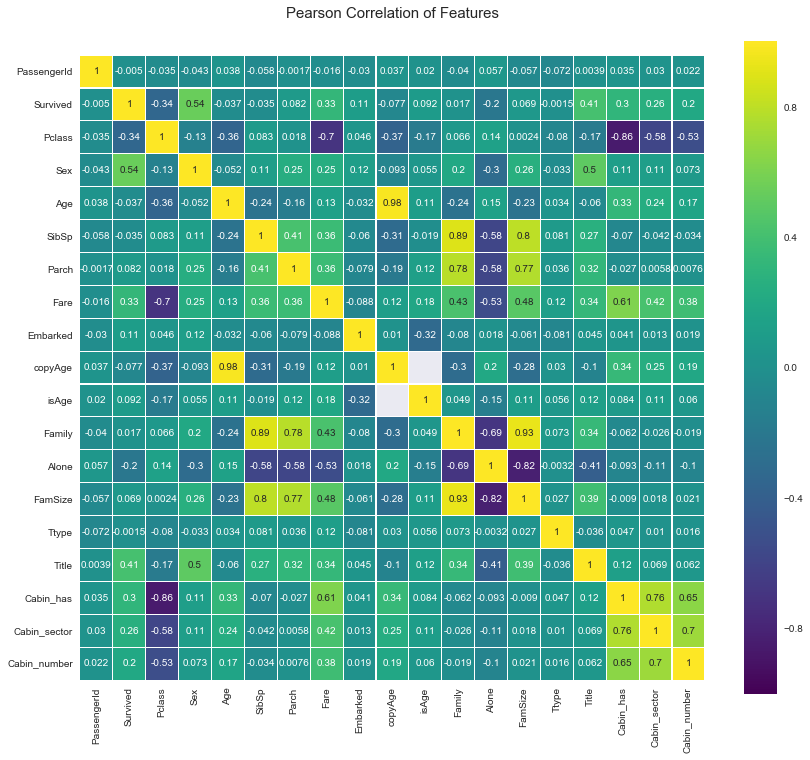

In [467]:
colormap = plt.cm.viridis
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(training.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

We can see that there is not many highly correlated feature. It means that each feature holds some information for learning.

## Preparing the model

Let's start from defining our data as X_train and y_train and X_test that will remain unmodified

In [468]:
#training = temp.copy()
#testing = temp2.copy()

In [469]:
temp = training.copy()
temp2 = testing.copy()

In [471]:
#training = training[training.isAge=='1']
training = training[["Survived","PassengerId",'Age','Sex','Pclass','Title','FamSize']]
testing = testing[["PassengerId",'Age','Sex','Pclass','Title','FamSize']]

X_train_ = training.drop(["Survived","PassengerId"], axis=1)
y_train_ = training["Survived"]
X_test_  = testing.drop(["PassengerId"], axis=1).copy()
X_train_.shape, y_train_.shape, X_test_.shape

((891, 5), (891,), (418, 5))

In [472]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
PassengerId    418 non-null int64
Age            418 non-null int32
Sex            418 non-null int32
Pclass         418 non-null int64
Title          418 non-null int64
FamSize        418 non-null int64
dtypes: int32(2), int64(4)
memory usage: 16.4 KB


Splitting to train test that we will use

In [473]:
X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train_,
                                                    train_size=0.8, random_state=None)

Check the shapes of subsets

In [474]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 5), (179, 5), (712,), (179,))

#### Model Selection

In [475]:
SEED = 0

rfc = RandomForestClassifier(random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
gbc = GradientBoostingClassifier(random_state=SEED)
#xgb = XGBClassifier(seed=SEED)
lre = LogisticRegression(random_state=SEED)
svc = SVC(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=3)
gau = GaussianNB()
lsv = LinearSVC(random_state=SEED)
dtc = DecisionTreeClassifier(random_state=SEED)
per = Perceptron(random_state=SEED)
sgd = SGDClassifier(random_state=SEED)

#models = [rfc, etc, gbc, xgb, lre, svc, knn, gau, lsv, dtc, per, sgd]
models = [rfc, etc, gbc, lre, svc, knn, gau, lsv, dtc, per, sgd]

After defining list of models we can now check their accuracy and f1 score

In [476]:
result = ""

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result += 'Model: {:.12}\nAccuracy: {:.5f}\nF1: {:13.5f}\n\n'.format(str(model),
                                                                 round(model.score(X_test, y_test)*100,2),
                                                                 round(f1_score(y_test,y_pred)*100,2))
    
print(result)

Model: RandomForest
Accuracy: 78.77000
F1:      71.21000

Model: ExtraTreesCl
Accuracy: 82.68000
F1:      77.04000

Model: GradientBoos
Accuracy: 82.68000
F1:      77.70000

Model: LogisticRegr
Accuracy: 82.12000
F1:      77.14000

Model: SVC(C=1.0, c
Accuracy: 83.80000
F1:      79.14000

Model: KNeighborsCl
Accuracy: 82.68000
F1:      78.01000

Model: GaussianNB(p
Accuracy: 82.68000
F1:      78.32000

Model: LinearSVC(C=
Accuracy: 81.56000
F1:      76.26000

Model: DecisionTree
Accuracy: 82.68000
F1:      77.04000

Model: Perceptron(a
Accuracy: 76.54000
F1:      66.13000

Model: SGDClassifie
Accuracy: 75.98000
F1:      63.87000




We see that best classifier is  SVC, second appears to be Linear SVC and third is Random Forest.

Let's check feature importances for models where we have that possibility

In [477]:
#modelsF = [rfc,etc,gbc,xgb,dtc]
modelsF = [rfc,etc,gbc,dtc]

In [478]:
start=True
for model in modelsF:
    if start == True:
        features = pd.DataFrame([model.feature_importances_], columns=list(X_train.columns))
        start=False
    else:
        features = pd.concat([features, pd.DataFrame([model.feature_importances_], columns=list(X_train.columns))])
features

,Age,Sex,Pclass,Title,FamSize
0,0.147532,0.362893,0.201097,0.126872,0.161606
0,0.108570,0.406180,0.195093,0.138252,0.151905
0,0.307753,0.051354,0.253658,0.243224,0.144011
0,0.096555,0.019512,0.201217,0.574033,0.108684


Now we can add mean and max feature importances for brief information

In [479]:
features['mean'] = features.mean(axis= 1)
features['min'] = features.min(axis= 1)
features['max'] = features.max(axis=1)
#features.index = ['rfc','etc','gbc','xgb','dtc']
features.index = ['rfc','etc','gbc','dtc']
features.head()

,Age,Sex,Pclass,Title,FamSize,mean,min,max
rfc,0.147532,0.362893,0.201097,0.126872,0.161606,0.2,0.126872,0.362893
etc,0.108570,0.406180,0.195093,0.138252,0.151905,0.2,0.108570,0.406180
gbc,0.307753,0.051354,0.253658,0.243224,0.144011,0.2,0.051354,0.307753
dtc,0.096555,0.019512,0.201217,0.574033,0.108684,0.2,0.019512,0.574033


### Parameter optimization

We will use GridSearch to look for best parameters for each model.

In [480]:
params = [[{
    'n_estimators': (9,10,12,11,25,50,90,100,110,150)},
    {
    'max_depth': (None,5,10,15,25)},
    {
    'min_samples_split': (2,3,4,5)},
    {
    'min_samples_leaf': (1,2,3,4,5,6)},
    {
    'max_features': (None, 'auto','sqrt','log2')
    }],

    [{
    'n_estimators': (8,9,10,11,12,13,15,25,40,50)},
    {
    'max_depth': (None,5,10,15,25)},
    {
    'min_samples_split': (2,3,4,5)},
    {
    'min_samples_leaf': (1,2,3,4)},
    {
    'max_features': (None, 'auto','sqrt','log2')
    }],

    [{
    'loss': ('deviance','exponential')},
    {
    'n_estimators': (50,100,150,200)},
    {
    'learning_rate': (0.01,0.1,0.2,0.3)},
    {
    'max_depth': (3,5,10,15,25)},
    {
    'min_samples_split': (2,3,4,5)},
    {
    'min_samples_leaf': (1,2,3,4)},
    {
    'max_features': (None, 'auto','sqrt','log2')
    }],

#    [{
#    'max_depth': (2,3,4,5)},
#    {
#    'n_estimators': (50,100,150,200,300)},
#    {
#    'learning_rate': (0.01,0.1,0.2,0.3)},
#    {
#    'reg_alpha': (0,0.1,0.2)},
#    {
#    'reg_lambda': (1,1,1,1.2)
#    }],

    [{
    'penalty': ('l1','l2')},
    {
    'fit_intercept': (True,False)},
    {
    'C': (1.2,1,0.8,0.6)},      
    {
    'warm_start': (True,False)
    }],
    
    [{
    'C': (1.2,1,0.8,0.6)},
    ], 
    
    [{
    'weights': ('distance','uniform')},
    {
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')},
    {
    'leaf_size': (25,28,30,32,35)},
    {
    'p': (1,2)},
    {
    'n_neighbors': (5,7,9,12,15,20)},
    ],
    
    [{
    }],

    [{
    'C': (1.2,1,0.8,0.6)}
    ],
    
    [{
    'criterion': ('gini', "entropy")},
    {
    'splitter': ('best','random')},
    {
    'max_depth': (None, 5, 15, 45, 85, 150)},
    {
    'min_samples_split': (2,3,4,5)},
    {
    'min_samples_leaf': (1,2,3)},
    {
    'max_features': (None, 'auto','sqrt','log2')},
    {
    'max_leaf_nodes': (None, 20, 50, 80, 120, 200)},
    {
    'presort': (True, False)}
    ],
    
    [{
    'penalty': (None, 'l1', 'l2', 'elasticnet')},
    {
    'fit_intercept': (True, False)},
    {
    'alpha': (0.0001,0.001,0.01)},
    {
    'n_iter': (5,10,15)},
    {
    'shuffle': (True, False)},
    {
    'warm_start': (True, False)}
    ],

    [{
    'loss': (['hinge', 'log', 'modified_huber', 'perceptron', \
             'huber', 'epsilon_insensitive'])},
    {
    'fit_intercept': (True, False)},
    {
    'alpha': (0.0001,0.001,0.01)},
    {
    'n_iter': (5,10,15)},
    {
    'shuffle': (True, False)},
    {
    'warm_start': (True, False)}, 
    {
    'epsilon': (0.05,0.1,0.2,0.3)},  
    {
    'penalty': (None, 'l1', 'l2', 'elasticnet')}
    ]
     
]

In [481]:
grid_res = ""
modelsCV = []

for num, model in enumerate(models):
    model = GridSearchCV(estimator=models[num],param_grid=params[num])
    model.fit(X_train,y_train)
    grid_res += 'Model: {:.20}\nAccuracy: {:.5f}\nEstimator: {}\n\n'.format(str(models[num]),
                                                                 model.best_score_,
                                                                 model.best_estimator_)
    modelsCV.append(model.best_estimator_)
print(grid_res)

Model: RandomForestClassifi
Accuracy: 0.82303
Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

Model: ExtraTreesClassifier
Accuracy: 0.83567
Estimator: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=5, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

Model: GradientBoostingClas
Accuracy: 0.82163
Estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
            

We can check what are the best parameters for the first classifier

In [482]:
modelsCV[0]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

### Training models with optimized parameters

In [483]:
result_val = ""

for model in modelsCV:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result_val += 'Model: {:.20}\nAccuracy: {:.5f}\nF1: {:13.5f}\n\n'.format(str(model),
                                                                 model.score(X_test, y_test),
                                                                 f1_score(y_test,y_pred))

print(result_val)

Model: RandomForestClassifi
Accuracy: 0.79330
F1:       0.72180

Model: ExtraTreesClassifier
Accuracy: 0.83799
F1:       0.79137

Model: GradientBoostingClas
Accuracy: 0.83799
F1:       0.79137

Model: LogisticRegression(C
Accuracy: 0.82123
F1:       0.77143

Model: SVC(C=1, cache_size=
Accuracy: 0.83799
F1:       0.79137

Model: KNeighborsClassifier
Accuracy: 0.78212
F1:       0.69291

Model: GaussianNB(priors=No
Accuracy: 0.82682
F1:       0.78322

Model: LinearSVC(C=1.2, cla
Accuracy: 0.81564
F1:       0.76259

Model: DecisionTreeClassifi
Accuracy: 0.83240
F1:       0.78571

Model: Perceptron(alpha=0.0
Accuracy: 0.59777
F1:       0.07692

Model: SGDClassifier(alpha=
Accuracy: 0.75419
F1:       0.62069




Again we can see that SVC scored the best using this dataset.

## Additional code for preparing file for Kaggle

Assign new name for X provided by Kaggle

In [484]:
X_kaggle = X_test_

Check shape

In [485]:
X_kaggle.shape

(418, 5)

Use best model on whole dataset (not splitted) and predict labels for X_kaggle data.
Export labels to CSV.

In [486]:
model_final = modelsCV[0].fit(X_train_,y_train_)
predictions = model_final.predict(X_kaggle)

PassengerId = np.array(testing["PassengerId"]).astype(int)
my_solution = pd.DataFrame(predictions, PassengerId, columns = ["Survived"])
my_solution.to_csv("results/result1.csv", index_label = ["PassengerId"])

# Another approach modyfying Dataset from categorical to "one-hot"

In [96]:
training.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'isAge', 'Family', 'Alone', 'FamSize', 'Ttype',
       'Title', 'Cabin_sector', 'Cabin_number'],
      dtype='object')

In [97]:
training.shape, testing.shape

((714, 17), (418, 16))

In [98]:
#testing['Survived']=np.NaN

In [99]:
all_data = pd.concat([training.drop(["PassengerId"], axis=1),testing.drop(["PassengerId"], axis=1)]).astype(object)

In [100]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132 entries, 0 to 417
Data columns (total 16 columns):
Age             1132 non-null object
Alone           1132 non-null object
Cabin_number    1132 non-null object
Cabin_sector    1132 non-null object
Embarked        1132 non-null object
FamSize         1132 non-null object
Family          1132 non-null object
Fare            1132 non-null object
Parch           1132 non-null object
Pclass          1132 non-null object
Sex             1132 non-null object
SibSp           1132 non-null object
Survived        714 non-null object
Title           1132 non-null object
Ttype           1132 non-null object
isAge           1132 non-null object
dtypes: object(16)
memory usage: 150.3+ KB


In [101]:
all_data_dummy = pd.get_dummies(all_data, drop_first=True)

In [102]:
all_data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132 entries, 0 to 417
Data columns (total 70 columns):
Age_1             1132 non-null uint8
Age_2             1132 non-null uint8
Age_3             1132 non-null uint8
Age_4             1132 non-null uint8
Age_5             1132 non-null uint8
Age_6             1132 non-null uint8
Age_7             1132 non-null uint8
Alone_1           1132 non-null uint8
Cabin_number_1    1132 non-null uint8
Cabin_number_2    1132 non-null uint8
Cabin_number_3    1132 non-null uint8
Cabin_number_4    1132 non-null uint8
Cabin_number_5    1132 non-null uint8
Cabin_number_6    1132 non-null uint8
Cabin_sector_1    1132 non-null uint8
Cabin_sector_2    1132 non-null uint8
Cabin_sector_3    1132 non-null uint8
Cabin_sector_4    1132 non-null uint8
Cabin_sector_5    1132 non-null uint8
Cabin_sector_6    1132 non-null uint8
Cabin_sector_7    1132 non-null uint8
Embarked_1        1132 non-null uint8
Embarked_2        1132 non-null uint8
FamSize_1         11

In [103]:
training_dummy = all_data_dummy[:training.shape[0]]
testing_dummy = all_data_dummy[training.shape[0]:]

In [104]:
X_train_ = training_dummy.drop(["Survived_1.0"], axis=1)
y_train_ = training_dummy["Survived_1.0"]
X_test_  = testing_dummy.drop(["Survived_1.0"], axis=1).copy()
X_train_.shape, y_train_.shape, X_test_.shape

((714, 69), (714,), (418, 69))

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train_,
                                                    train_size=0.8, random_state=None)

In [106]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((571, 69), (143, 69), (571,), (143,))

In [107]:
result = ""

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result += 'Model: {:.12}\nAccuracy: {:.5f}\nF1: {:13.5f}\n\n'.format(str(model),
                                                                 round(model.score(X_test, y_test)*100,2),
                                                                 round(f1_score(y_test,y_pred)*100,2))
    
print(result)

Model: RandomForest
Accuracy: 78.32000
F1:      70.48000

Model: ExtraTreesCl
Accuracy: 80.42000
F1:      73.08000

Model: GradientBoos
Accuracy: 84.62000
F1:      80.36000

Model: LogisticRegr
Accuracy: 85.31000
F1:      81.42000

Model: SVC(C=1.0, c
Accuracy: 81.12000
F1:      74.77000

Model: KNeighborsCl
Accuracy: 77.62000
F1:      70.91000

Model: GaussianNB(p
Accuracy: 44.76000
F1:      59.90000

Model: LinearSVC(C=
Accuracy: 85.31000
F1:      81.74000

Model: DecisionTree
Accuracy: 79.72000
F1:      73.39000

Model: Perceptron(a
Accuracy: 71.33000
F1:      72.11000

Model: SGDClassifie
Accuracy: 76.22000
F1:      75.36000




In [108]:
grid_res = ""
modelsCV = []

for num, model in enumerate(models):
    model = GridSearchCV(estimator=models[num],param_grid=params[num])
    model.fit(X_train,y_train)
    grid_res += 'Model: {:.20}\nAccuracy: {:.5f}\nEstimator: {}\n\n'.format(str(models[num]),
                                                                 model.best_score_,
                                                                 model.best_estimator_)
    modelsCV.append(model.best_estimator_)
print(grid_res)

Model: RandomForestClassifi
Accuracy: 0.78984
Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

Model: ExtraTreesClassifier
Accuracy: 0.79159
Estimator: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=5, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

Model: GradientBoostingClas
Accuracy: 0.81786
Estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
            

In [109]:
result_val = ""

for model in modelsCV:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result_val += 'Model: {:.20}\nAccuracy: {:.5f}\nF1: {:13.5f}\n\n'.format(str(model),
                                                                 model.score(X_test, y_test),
                                                                 f1_score(y_test,y_pred))

print(result_val)

Model: RandomForestClassifi
Accuracy: 0.79021
F1:       0.72222

Model: ExtraTreesClassifier
Accuracy: 0.81818
F1:       0.75000

Model: GradientBoostingClas
Accuracy: 0.83916
F1:       0.79279

Model: LogisticRegression(C
Accuracy: 0.85315
F1:       0.81416

Model: SVC(C=1.2, cache_siz
Accuracy: 0.81119
F1:       0.74766

Model: KNeighborsClassifier
Accuracy: 0.79720
F1:       0.73394

Model: GaussianNB(priors=No
Accuracy: 0.44755
F1:       0.59898

Model: LinearSVC(C=1.2, cla
Accuracy: 0.85315
F1:       0.81739

Model: DecisionTreeClassifi
Accuracy: 0.81119
F1:       0.75229

Model: Perceptron(alpha=0.0
Accuracy: 0.69930
F1:       0.69504

Model: SGDClassifier(alpha=
Accuracy: 0.85315
F1:       0.81739




In [110]:
X_kaggle = X_test_

In [111]:
X_kaggle.shape

(418, 69)

In [112]:
model_final = modelsCV[7].fit(X_train_,y_train_)
predictions = model_final.predict(X_kaggle)

PassengerId = np.array(testing["PassengerId"]).astype(int)
my_solution = pd.DataFrame(predictions, PassengerId, columns = ["Survived"])
my_solution.to_csv("results/result2.csv", index_label = ["PassengerId"])

clf = clf_ext
scores = cross_val_score(clf, X, y, cv=5)
print(scores)
print("Mean score = %.3f, Std deviation = %.3f"%(np.mean(scores),np.std(scores)))

combine = pd.concat([train.drop('Survived',1),test])
survived = train['Survived']

combine['Child'] = combine['Age']<=10
combine['Cabin_known'] = combine['Cabin'].isnull() == False
combine['Age_known'] = combine['Age'].isnull() == False
combine['Family'] = combine['SibSp'] + combine['Parch']
combine['Alone']  = (combine['SibSp'] + combine['Parch']) == 0
combine['Large_Family'] = (combine['SibSp']>2) | (combine['Parch']>3)
combine['Deck'] = combine['Cabin'].str[0]
combine['Deck'] = combine['Deck'].fillna(value='U')
combine['Ttype'] = combine['Ticket'].str[0]
combine['Title'] = combine['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
combine['Fare_cat'] = pd.DataFrame(np.floor(np.log10(combine['Fare'] + 1))).astype('int')
combine['Bad_ticket'] = combine['Ttype'].isin(['3','4','5','6','7','8','A','L','W'])
combine['Young'] = (combine['Age']<=30) | (combine['Title'].isin(['Master','Miss','Mlle']))
combine['Shared_ticket'] = np.where(combine.groupby('Ticket')['Name'].transform('count') > 1, 1, 0)
combine['Ticket_group'] = combine.groupby('Ticket')['Name'].transform('count')
combine['Fare_eff'] = combine['Fare']/combine['Ticket_group']
combine['Fare_eff_cat'] = np.where(combine['Fare_eff']>16.0, 2, 1)
combine['Fare_eff_cat'] = np.where(combine['Fare_eff']<8.5,0,combine['Fare_eff_cat'])
test = combine.iloc[len(train):]
train = combine.iloc[:len(train)]
train['Survived'] = survived

surv = train[train['Survived']==1]
nosurv = train[train['Survived']==0]

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()